In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import numpy as np
ds_train, ds_test = tfds.load('genomics_ood', split=['train', 'test'], shuffle_files=True, as_supervised=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/12 [00:00<?, ? file/s]


Dataset genomics_ood downloaded and prepared to /root/tensorflow_datasets/genomics_ood/0.0.1. Subsequent calls will reuse this data.


In [1]:
def onehotify(tensor):
  vocab = {'A':'0', 'C':'1', 'G':'2', 'T':'3'}
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key])
  split = tf.strings.bytes_split(tensor)
  labels = tf.cast(tf.strings.to_number(split), tf.int64)
  onehot = tf.one_hot(labels, 4)
  onehot = tf.reshape(onehot, (-1,))
  return onehot

def prepare_dataset(ds):
  ds = ds.map(lambda seq, target: (onehotify(seq), tf.one_hot(target, 10)))
  ds = ds.cache()
  ds = ds.batch(8)
  ds = ds.prefetch(20)
  return ds




In [4]:
test_dataset = ds_test.take(1000) 
train_dataset = ds_train.take(100000)

test_dataset = prepare_dataset(test_dataset)
train_dataset = prepare_dataset(train_dataset)

In [14]:
class SimpleDense(tf.keras.layers.Dense):

    def __init__(self, units=256, activation_func=tf.nn.sigmoid):
        super(SimpleDense, self).__init__()
        self.units_num = units
        self.activation_func = activation_func

    def build(self, input_shape): 
        self.w = self.add_weight(shape=(input_shape[-1], self.units_num),
                               initializer='random_normal',
                               trainable=True)
        self.b = self.add_weight(shape=(self.units_num,),
                               initializer='random_normal',
                               trainable=True)

    def call(self, inputs): 
        x = tf.matmul(inputs, self.w) + self.b
        y = self.activation(x)
        return y

#input_shape = tf.keras.Input(shape=(4,0))

class Model3(tf.keras.Model):

    def __init__(self):
        super(Model3, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.sigmoid)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.sigmoid)
        self.output_layer = tf.keras.layers.Dense(10, tf.nn.softmax)

    def call(self, inputs):
        return self.output_layer(self.dense2(self.dense1(inputs)))


In [15]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [16]:

### Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model.
model = Model3()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input, target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.131
Epoch: 1 starting with accuracy 0.373
Epoch: 2 starting with accuracy 0.374
Epoch: 3 starting with accuracy 0.374
Epoch: 4 starting with accuracy 0.373
Epoch: 5 starting with accuracy 0.404
Epoch: 6 starting with accuracy 0.405
Epoch: 7 starting with accuracy 0.426
Epoch: 8 starting with accuracy 0.407
Epoch: 9 starting with accuracy 0.402


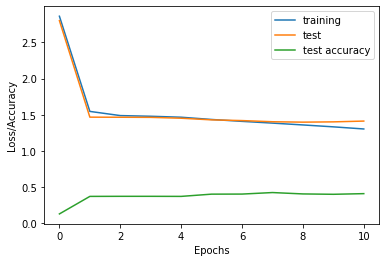

In [17]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()